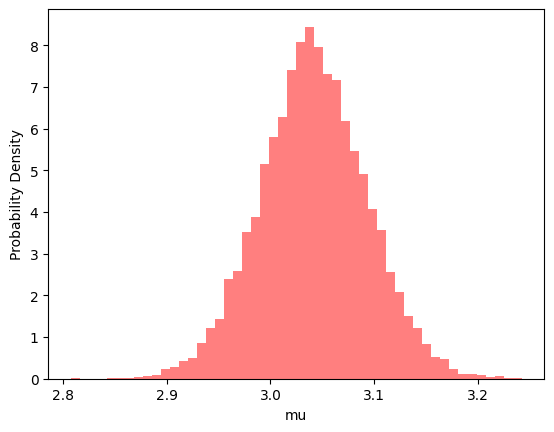

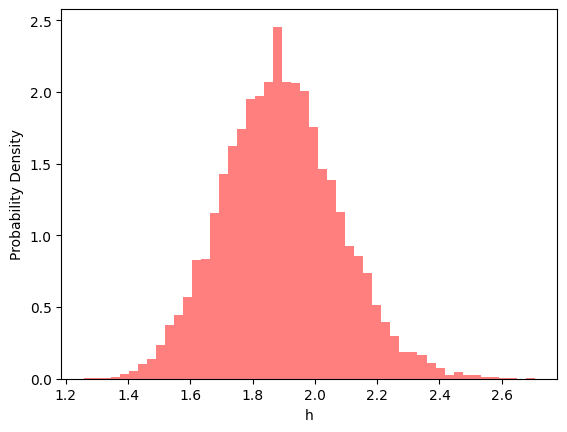

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Gibbs algorithm
def gibbs_sampler(data, n, mu0, h0, alpha0, delta0):
    # Initialization
    sample = np.zeros((n, 2))
    sample[0, 0] = mu0
    sample[0, 1] = alpha0 / delta0
    
    # Sampling
    for i in range(1, n):
        mu1 = (h0 * mu0 + sample[i - 1, 1] * sum(data)) / (h0 + sample[i - 1, 1] * len(data))
        h1 = h0 + sample[i - 1, 1] * len(data)
        sample[i, 0] = stats.norm.rvs(size=1, loc=mu1, scale=1 / np.sqrt(h1))
        
        alpha1 = alpha0 + len(data)
        delta1 = delta0 + sum((data - sample[i, 0])**2)
        sample[i, 1] = stats.gamma.rvs(alpha1 / 2, size=1, scale=2 / delta1)
        
    return sample

# Generate data
np.random.seed(0)
mu = 3
h = 2
data = stats.norm.rvs(loc=mu, scale=1 / np.sqrt(h), size=200)

# Prior and posterior
mu0 = 0
h0 = 1
alpha0 = 2
delta0 = 2
sample = gibbs_sampler(data, 11000, mu0, h0, alpha0, delta0)
sample = sample[1000:11000, :]

# Plot
plt.hist(sample[:, 0], bins=50, density=True, color="red", alpha=0.5)
plt.xlabel("mu")
plt.ylabel("Probability Density")
plt.show()
plt.hist(sample[:, 1], bins=50, density=True, color="red", alpha=0.5)
plt.xlabel("h")
plt.ylabel("Probability Density")
plt.show()

In [3]:
# Marginal likelihood by Chib (1995)
def marg_lik(data, sample, mu, h, mu0, h0, alpha0, delta0):
    mu1 = (h0 * mu0 + sample[:, 1] * sum(data)) / (h0 + sample[:, 1] * len(data))
    h1 = h0 + sample[:, 1] * len(data)
    log_post1 = np.log(np.mean(stats.norm.pdf(mu, loc=mu1, scale=1 / np.sqrt(h1))))

    alpha1 = alpha0 + len(data)
    delta1 = delta0 + sum((data - mu)**2)
    log_post2 = stats.gamma.logpdf(h, alpha1 / 2, scale=2 / delta1)

    log_lik = sum(stats.norm.logpdf(data, loc=mu, scale=1 / np.sqrt(h)))
    log_prior = stats.norm.logpdf(mu, loc=mu0, scale=1 / np.sqrt(h0)) + stats.gamma.logpdf(h, alpha0 / 2, scale=2 / delta0)

    return log_lik + log_prior - log_post1 - log_post2

log_ml = marg_lik(data, sample, mu, h, mu0, h0, alpha0, delta0)
print(log_ml)

-228.96919208688195


Rejection rate: 0.421


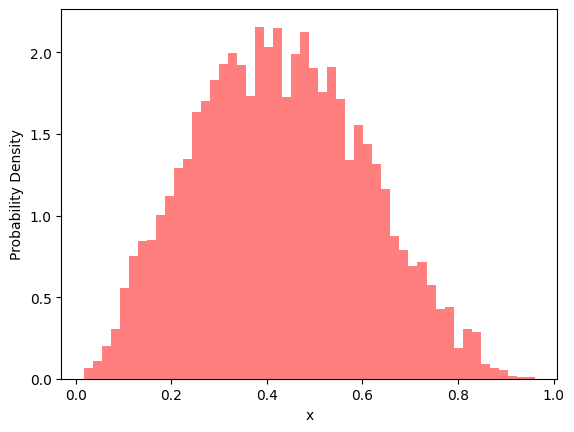

In [8]:
# Metropolis-Hastings algorithm
def mh_sampler(n):
    prop = np.zeros(n)
    sample = np.zeros(n)
    prop[0] = 0.5
    sample[0] = prop[0]
    rej = 0

    for i in range(1, n):
        prop[i] = np.random.rand(1)
        alpha = min(1, stats.beta.pdf(prop[i], 3, 4) / stats.beta.pdf(sample[i - 1], 3, 4))
        if np.random.rand(1) > alpha:   # reject
            rej += 1
            sample[i] = sample[i - 1]
        else:   # accept
            sample[i] = prop[i]

    return prop, sample, rej

prop, sample, rej = mh_sampler(11000)
prop = prop[1000:11000]
sample = sample[1000:11000]
print(f"Rejection rate: {rej / 11000}")

# Plot
plt.hist(sample, bins=50, density=True, color="red", alpha=0.5)
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.show()

In [12]:
# Marginal likelihood by Chib & Jeliazkov (2001)
def post_ord(prop, sample, x):
    n = len(sample)
    num = np.zeros(n)
    den = np.zeros(n)

    for i in range(n):
        num[i] = min(1, stats.beta.pdf(x, 3, 4) / stats.beta.pdf(sample[i], 3, 4))
        den[i] = min(1, stats.beta.pdf(prop[i], 3, 4) / stats.beta.pdf(x, 3, 4))

    return np.log(np.mean(num)) - np.log(np.mean(den))

log_po = post_ord(prop, sample, 0.5)
print(log_po)
print(stats.beta.logpdf(0.5, 3, 4))

0.6242719383775133
0.6286086594223743
